# Part 1

## IMPORTS

In [1]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

In [2]:
#Import data
data=pd.read_csv('wmap.csv')

## Functions

Here we define the function generating the Power Function $G_{d,q}$ as defined in the homework assignment and then plot some of its elements for d=1, q=3 in the open interval $(0,1)$.

In [3]:
def power_func(x,d,q):
    #Generate power function for given d,q
    #list in which we store g_i's
    G=[]
    #convert to array
    x=np.array(x)
    j=1
    
    #cicle to assign single g_i's
    for i in range(0,(d+1+q)):
        if i<(d+1):
            G.append(x**i)
        else:
            #split interval of x axis by q points
            sottr=x[-1]/(q+1)*j 
            G.append((np.maximum(0,x-sottr))**d)
            j+=1
            
    return G

In the following we report the functions used to realize different analyses on our data, we'll talk about each of them in the respective section.

In [7]:
def pre_processing(x,d,q):
    #Generates matrix X (in homework assignment) from power function
    mat=power_func(x,d,q)
    mat=np.array(mat)
    return np.transpose(mat)

In [8]:
def GCV_score (d,q,x=data.x,y=data.y):
    #Computes GCV score using splines
    
    #Generate X
    X = pre_processing(x,d,q)
    #Fit model on data
    plm = LinearRegression(fit_intercept=False).fit(X,data.y)
    #Make predictions
    Y_hat = plm.predict(X)
    #Compute MSE
    MSE_tr = mean_squared_error(y,Y_hat)
    #and GCV score
    GCV_score=MSE_tr/((1-((d+1)/len(x)))**2)
    return GCV_score

In [9]:
def assign_folds(k,d=data):
    #Generates k folds using stratified sampling for given pandas dataframe
    
    #k=n_folds>1
    if k<=1:
        raise TypeError("Only integers >1 are allowed") 
    
    #Here we store the folds
    folds=[]
    
    #Assign classes (for stratified sampling)
    d.loc[0:399,'class']=0
    d.loc[400:900,'class']=1
    d=d.astype({'class':int})
    
    #Assign a column to determine whether a row has already been used or not (avoid sampling twice the same row)
    d.loc[0:900,'picked'] = 0

    #Create folds
    for i in range(k):
        #sample 1/k rows of the initial dataframe (the '-i' solves the problem related to the fact we are reducing the size of 
        #the dataframe at each iteration because we only consider rows with 'picked'==0)
        sample=d[d['picked']==0].groupby('class', group_keys=False).apply(lambda x: x.sample(frac=1/(k-i))) 
        #set to 1 the picked rows
        d.loc[sample.index,'picked']=1
        #save the single fold
        folds.append(sample)   
        
    return (folds)

In [10]:
def SCV_score(d,q,k,df):
    #Computes the score for the stratified cross validation (SCV)
    
    #assign folds
    folds=assign_folds(k,df)
    #save results
    SCV=[]
    
    for i in range(len(folds)):
        val=folds[i]
        #Remove rows of the single folder (we need it for the testing)
        tr=df.drop(val.index)
        #just a simple renaming
        x=tr.x
        y=tr.y
        #same here
        x_out=val.x
        y_out=val.y
        
        #generate matrix X to train the model
        X = pre_processing(x,d,q)
        #generate matrix X_out to make predictions using the model
        X_out = pre_processing(x_out,d,q)
        #train model
        plm = LinearRegression(fit_intercept=False).fit(X,y)
        
        #make prediction
        Y_hat = plm.predict(X_out)
        #compute and store MSE value
        MSE_cv = mean_squared_error(y_out,Y_hat)
        SCV.append(MSE_cv)
    return np.mean(SCV)

In [25]:
def CP_score(d,q,x,y):
    #Computes the score for the Mallows' CP
    
    #generate X
    X = pre_processing(x,d,q)
    #train model
    plm = LinearRegression(fit_intercept=False).fit(X,y)
    #predict
    Y_hat = plm.predict(X)
    #compute residuals
    sigma_sq = np.sum((Y_hat-data.y)**2)/(len(x)-d+1)
    #and mse
    MSE_tr = mean_squared_error(y,Y_hat)
    #compute CP
    CP=MSE_tr+ 2*sigma_sq*(d+1)/len(x)
    return CP

In [12]:
def main(d,q,type_,df):
    #returns requested score by specifying variable type_
    x=df.x
    y=df.y
    if type_=='GCV':
        scores=GCV_score(d,q,x,y)
    elif type_=='SCV':
        scores=SCV_score(d,q,10,df)
    elif type_== 'CP':
        scores = CP_score(d,q,x,y)
    return round(scores,2)

# 1.2 - Plotting of power function

In [42]:
x=list(np.linspace(0,1,1000))
G1=power_func(x,1,3)
G3=power_func(x,3,3)

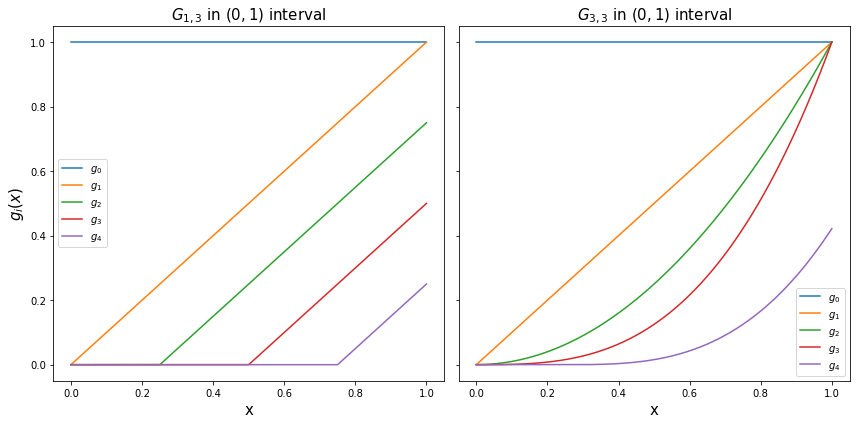

In [46]:
#Plot the loss function
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(12,6))

for i in range(0,5):
    ax1.plot(x, G1[i], label =(r"$g_{}$").format(i))
    ax2.plot(x, G3[i], label =(r"$g_{}$").format(i))
    
ax1.set_title(r'$G_{1,3}$ in $(0,1)$ interval',fontsize=15)
ax1.set_xlabel('x',fontsize=15)
ax1.set_ylabel(r'$g_i(x)$',fontsize=15)

ax2.set_title(r'$G_{3,3}$ in $(0,1)$ interval',fontsize=15)
ax2.set_xlabel('x',fontsize=15)


ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()



# 1.3

To compute the GCV score as requested in part 1.3 of the homework we chose to fix the value of d while searching for score minima evaluating for different q's.

## GCV

### d=3

In [26]:
d=3

Optimal q in (1,20) for d = 3 is q = 19, with residuals score = 9107396.91


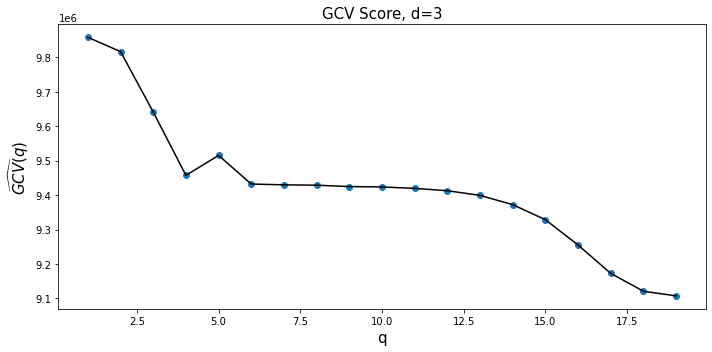

In [47]:
#We chose to take  knots in range (1,20) and look for minima in there
knots=list(range(1,20))
#apply the GCV method to data making q vary
res=list(map(main,[d]*len(knots),knots,['GCV']*len(knots),[data]*len(knots)))
#retrieve index of min value for residuals
ind=np.argmin(res)

print(('Optimal q in (1,20) for d = 3 is q = {}, with residuals score = {}').format(knots[ind],res[ind]))

plt.figure(figsize=(10,5))
plt.scatter(knots,res)
plt.plot(knots,res,color='black')
plt.title(r'GCV Score, d=3',fontsize=15)
plt.xlabel('q',fontsize=15)
plt.ylabel(r'$\widehat{GCV}(q)$',fontsize=15)
plt.tight_layout()
plt.show()

### d=1

In [48]:
d=1

Optimal q in (1,20) for d = 1 is q = 18, with residuals score = 9324213.82


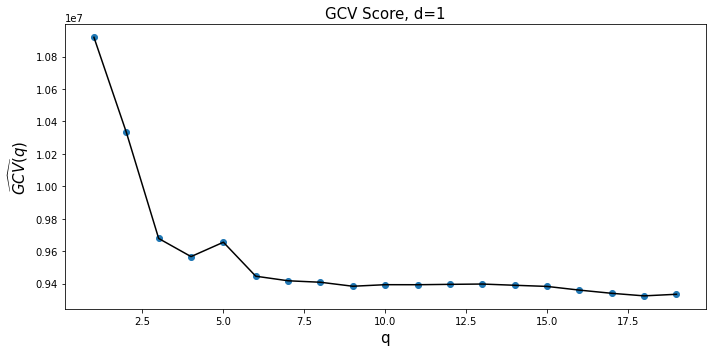

In [49]:
#We chose to take  knots in range (1,20) and look for minima in there
knots=list(range(1,20))
#apply the GCV method to data making q vary
res=list(map(main,[d]*len(knots),knots,['GCV']*len(knots),[data]*len(knots)))
#retrieve index of min value for residuals
ind=np.argmin(res)

print(('Optimal q in (1,20) for d = 1 is q = {}, with residuals score = {}').format(knots[ind],res[ind]))

plt.figure(figsize=(10,5))
plt.scatter(knots,res)
plt.plot(knots,res,color='black')
plt.title(r'GCV Score, d=1',fontsize=15)
plt.xlabel('q',fontsize=15)
plt.ylabel(r'$\widehat{GCV}(q)$',fontsize=15)
plt.tight_layout()
plt.show()

## Stratified CV

Optimal q in (1,20) for d = 1 is q = 1, with residuals score = 10981256.44
Optimal q in (1,20) for d = 3 is q = 1, with residuals score = 89051359.87


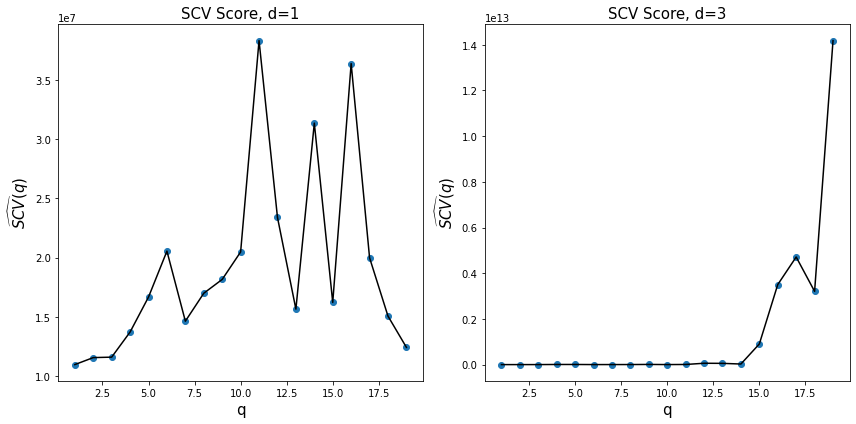

In [58]:
#d=1
#We chose to take  knots in range (1,20) and look for minima in there
knots=list(range(1,20))
#apply the GCV method to data making q vary
res1=list(map(main,[1]*len(knots),knots,['SCV']*len(knots),[data]*len(knots)))
#retrieve index of min value for residuals
ind1=np.argmin(res1)

#d=3
res2=list(map(main,[3]*len(knots),knots,['SCV']*len(knots),[data]*len(knots)))
ind2=np.argmin(res2)

print(('Optimal q in (1,20) for d = 1 is q = {}, with residuals score = {}').format(knots[ind1],res1[ind1]))
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(12,6))
ax1.scatter(knots,res1)
ax1.plot(knots,res1,color='black')
ax1.set_title(r'SCV Score, d=1',fontsize=15)
ax1.set_xlabel('q',fontsize=15)
ax1.set_ylabel(r'$\widehat{SCV}(q)$',fontsize=15)

print(('Optimal q in (1,20) for d = 3 is q = {}, with residuals score = {}').format(knots[ind2],res2[ind2]))

ax2.scatter(knots,res2)
ax2.plot(knots,res2,color='black')
ax2.set_title(r'SCV Score, d=3',fontsize=15)
ax2.set_xlabel('q',fontsize=15)
ax2.set_ylabel(r'$\widehat{SCV}(q)$',fontsize=15)

fig.tight_layout()
plt.show()

## Mallows' Cp

18 9324075.58


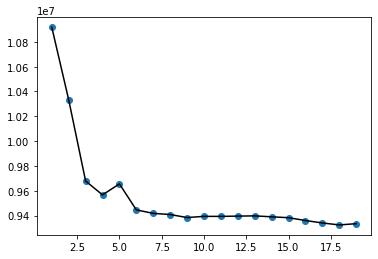

In [16]:
# for d=3 
knots=list(range(1,20))
# print(knots)
res=list(map(main,[1]*len(knots),knots,['CP']*len(knots),[data]*len(knots)))
ind=np.argmin(res)
print(knots[ind],res[ind])
plt.scatter(knots,res)
plt.plot(knots,res,color='black')
plt.show()

# porcherie

In [17]:
res

[10918165.83,
 10332847.23,
 9677970.4,
 9566319.36,
 9654859.88,
 9445322.64,
 9417146.01,
 9408051.58,
 9383420.54,
 9393053.92,
 9392786.93,
 9395122.6,
 9397044.04,
 9389458.05,
 9382352.86,
 9359597.98,
 9339922.12,
 9324075.58,
 9333998.64]

In [18]:
data2=data[400:]

In [19]:
X=pre_processing(data.x,1,23)
print(X)


[[  1.    2.    0.  ...   0.    0.    0. ]
 [  1.    3.    0.  ...   0.    0.    0. ]
 [  1.    4.    0.  ...   0.    0.    0. ]
 ...
 [  1.  898.  860.5 ... 110.5  73.   35.5]
 [  1.  899.  861.5 ... 111.5  74.   36.5]
 [  1.  900.  862.5 ... 112.5  75.   37.5]]


In [20]:
plm=LinearRegression(fit_intercept=False).fit(X,data.y)
c=plm.coef_
c
score=plm.score(X,data.y)
score


0.15554534424977828

In [21]:
plm = LinearRegression(fit_intercept=False).fit(X,data.y)
Y_hat_ = plm.predict(X)
MSE_tr_ = mean_squared_error(data.y,Y_hat_)
GCV_score_ = MSE_tr_/((1-((3+1)/len(data.x)))**2)
print(MSE_tr_)

9275616.36382385


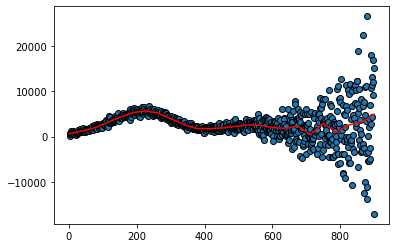

In [22]:
plt.scatter(data.x,data.y,edgecolors='black')
plt.plot(data.x,np.sum((X*c),axis=1),color='red')
plt.show()
# evidenzia i knots

In [23]:
p2=data
folds=assign_folds(5,p2)
SCV=[]
for i in range(len(folds)):
    val=folds[i]
    tr=p2.drop(val.index)
    x=tr.x
    y=tr.y
    x_out=val.x
    y_out=val.y
    #print(x_out)
    #print(tr.x)
    X = pre_processing(x,3,10)
    X_out = pre_processing(x_out,3,10)
    plm = LinearRegression(fit_intercept=False).fit(X,y)

    Y_hat = plm.predict(X_out)
    MSE_cv = mean_squared_error(y_out,Y_hat)
    SCV.append(MSE_cv)
np.mean(SCV)

22994597394.01547

# polyfit

In [24]:
# polynomial test
poly=np.polyfit(data.x,data.y,1)
y_hat=np.polyval(poly,data.x)
mse=mean_squared_error(data.y,y_hat)
mse/((1-4/len(data.x))**2)

10972715.673744118